In [3]:
import pandas as pd
import numpy as np
import json
import os
import requests
from datetime import datetime,timedelta
import time
import matplotlib.pyplot as plt
import math
import time

In [2]:
API_KEY = ''           # Enter API key from https://darksky.net/

## Methods

In [4]:
def drop_null_vals(df,axis='both',subset=[]):
    '''
    Drops columns with all
    nan values from a given 
    data frame.
    
    Parameters
    ----------
    df : DataFrame
        DataFrame for which
        columns are to be
        dropped.
        
    axis : str
        Drops all rows with
        nan if axis=rows,
        all columns if axis=columns,
        and both if axis=both.
        
    subset : list of str
        For all columns in
        subset, remove the
        NaN rows.
    '''
    assert(isinstance(df,pd.DataFrame))
    assert(isinstance(axis,str))
    assert(isinstance(subset,list))
    assert(isinstance(col,str) for col in subset)
    
    df = df.dropna(subset=subset)
    
    if(axis=='rows'):
        df = df.dropna(how='all',axis=0)
    elif(axis=='columns'):
        df = df.dropna(how='all',axis=1)
    elif(axis=='both'):
        df = df.dropna(how='all',axis=0).dropna(how='all',axis=1)
    
    return df

def getWeatherData(latitude,longitude,start_date,end_date):
    '''
    Returns temperature 
    and humidity data 
    as per the latitude 
    and longitude entered.
    
    Parameters
    ----------
    latitude : float
        Latitude of region
        for fetching the
        weather data
        
    longitude : float
        Longitude of region
        for fetching weather
        data
        
    start_date : str
        Start date to start 
        fetching weather data
        from.
        
    end_date : str
        End date to end 
        fetching weather data
        at.
    '''
    assert(isinstance(latitude,float))
    assert(isinstance(longitude,float))
    assert(isinstance(start_date,str))
    assert(isinstance(end_date,str))
    
    start_date = datetime.strptime(start_date,'%Y-%m-%d')
    end_date = datetime.strptime(end_date,'%Y-%m-%d')
    
    day_count = (end_date - start_date).days + 1
    temperature_list = []
    humidity_list = []
    
    for single_date in (start_date + timedelta(n) for n in range(day_count)):
        epoch_time = int(single_date.timestamp())
        url = createWeatherURL(latitude,longitude,epoch_time)
#         print("URL to get data: ",url)
        response = requests.get(url)
        lst = response.json()['hourly']['data']
        temp_list = []
        for l in lst:
            temp_list.append(l['temperature'])
    
        mean_day_temperature = sum(temp_list)/len(temp_list)
        temperature_list.append(mean_day_temperature)
        humidity_list.append(response.json()['daily']['data'][0]['humidity'])
        
    return sum(temperature_list)/len(temperature_list),sum(humidity_list)/len(humidity_list)

def createWeatherURL(latitude,longitude,epoch_time):
    '''
    Creates weather URL
    for given latitude,
    longitude and time.
    
    Parameters
    ----------
    latitude : float
        Latitude of the
        region for which
        data is to be fetched
        
    longitude : float
        Longitude of the
        region for which
        data is to be fetched
        
    epoch_time : int
        Time ending at which
        data is to be fetched
    '''
    assert(isinstance(latitude,float))
    assert(isinstance(longitude,float))
    assert(isinstance(epoch_time,int))
    
    url = 'https://api.darksky.net/forecast/'+API_KEY+'/'+str(latitude)+','+str(longitude)+','+str(epoch_time)+'?exclude=currently,flags,minutely'

    return url

def getIndexByRegion(province,country,df):
    '''
    Gets index of a region
    from a DataFrame.
    
    Parameters
    ----------
    province : str
        Province for which
        index is to be fetched
        
    Country : str
        Country for which
        index is to be fetched
        
    df : Pandas DataFrame
        DataFrame from which
        index is to be fetched
    '''
    assert(isinstance(country,str))
    assert(isinstance(df,pd.DataFrame))
    
    if(type(province)!=str and np.isnan(province)):
        idx = df[(df['Province/State'].isnull()) & (df['Country/Region']==country)].index
        return idx.to_list()[0]
    else:
        idx = df[(df['Province/State']==province) & (df['Country/Region']==country)].index
        return idx.to_list()[0]

def fetch_province_country_by_region(region):
    '''
    Given a region as
    Province,Country,
    returns the province
    and country or just
    the country if no province
    of the region.
    
    Parameters
    ----------
    region : str
        Region to be parsed
    '''
    assert(isinstance(region,str))
    
    result = region.split(",")
    if(len(result)==2):
        return result[0],result[1].strip()
    else:
        return np.NaN,region
    
def getPopulationByRegion(province,country,df):
    '''
    Given the province and
    country of a region,
    fetches the population
    from the dataframe.
    
    Parameters
    ----------
    province : str
        Province for which
        population is to be fetched
        
    Country : str
        Country for which
        population is to be fetched
        
    df : Pandas DataFrame
        DataFrame from which
        population is to be fetched
    
    '''
    assert(isinstance(country,str))
    assert(isinstance(df,pd.DataFrame))
    
    if(type(province)!=str and np.isnan(province)):
        population = df[(df['Province/State'].isnull()) & (df['Country/Region']==country)].Population
        return population.to_list()[0]
    else:
        population = df[(df['Province/State']==province) & (df['Country/Region']==country)].Population
        return population.to_list()[0]
    
def getDatesByRegion(region,df):
    '''
    Given the province and
    country of a region,
    fetches the infection
    duration from the dataframe.
    
    Parameters
    ----------
    province : str
        Province for which
        dates are to be fetched
        
    Country : str
        Country for which
        dates are to be fetched
        
    df : Pandas DataFrame
        DataFrame from which
        dates are to be fetched
    '''
    assert(isinstance(region,str))
    assert(isinstance(df,pd.DataFrame))
    
    region_row = df[df['Region']==region]
    start_date = region_row['Time series start'].to_list()[0]
    stop_date = region_row['Time series end'].to_list()[0]
    
    return start_date,stop_date

def getLearningRate(region,df):
    '''
    Given the province and
    country of a region,
    fetches the learning
    rate from the dataframe.
    
    Parameters
    ----------
    province : str
        Province for which
        learning rate is
        to be fetched
        
    Country : str
        Country for which
        learning rate is
        to be fetched
        
    df : Pandas DataFrame
        DataFrame from which
        learning rate is
        to be fetched
    '''
    assert(isinstance(region,str))
    assert(isinstance(df,pd.DataFrame))
    
    region_row = df[df['Region']==region]
    learning_rate = region_row['lr'].to_list()
#     print("Learning rate:",learning_rate)
    if(math.isnan(learning_rate[0])):
#         print("learning rate is null. returning 0.0004")
        return 0.0004
    else:
        return learning_rate[0]
    
def getWeatherDataForRegions(regions,time_series_confirmed,model_param_df):
    '''
    Given a list of regions,
    returns the map of region
    and its weather data.
    
    Parameters
    ----------
    regions : list
        List of regions for
        which data is to be
        fetched.

    time_series_confirmed : DataFrame
        DataFrame that contains
        time series data of
        number of confirmed
        cases all across the
        world.
        
    model_param_df : DataFrame
        DataFrame that contains
        parameters of the model 
        and weather data.
        
    '''
    assert(isinstance(regions,list))
    assert(isinstance(time_series_confirmed,pd.DataFrame))
    assert(isinstance(model_param_df,pd.DataFrame))
    assert(all(isinstance(region,str) for region in regions))
    
    result = {}
    
    for region in regions:
        try:
            province,country = fetch_province_country_by_region(region)
            region_idx = getIndexByRegion(province,country,time_series_confirmed)
            latitude = time_series_confirmed.loc[region_idx]['Lat']
            longitude = time_series_confirmed.loc[region_idx]['Long']
            df = model_param_df[model_param_df['Region']==region]
            start_date_index,end_date_index = getDatesByRegion(region,model_param_df)
            start_date = str(datetime.strptime(time_series_confirmed.columns[start_date_index], '%m/%d/%Y').date())
            end_date = str(datetime.strptime(time_series_confirmed.columns[end_date_index-1], '%m/%d/%Y').date())
#             print('latitude,longitude=',str(latitude)+","+str(longitude))
#             print('start date= "',start_date,end='"\n')
#             print('end date= "',end_date,end='"\n')
            result[region] = getWeatherData(latitude,longitude,start_date,end_date)
        except:
            print("ERROR while fetching data for: ",region)
        
    return result

## Data

### 3. Time series data (John Hopkins)

Time series data of number of confirmed cases all across the world.

In [5]:
try:
    confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
#     confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/archived_data/archived_time_series/time_series_19-covid-Confirmed_archived_0325.csv'
    deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
#     deaths_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/archived_data/archived_time_series/time_series_19-covid-Deaths_archived_0325.csv'
    recovered_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
#     recovered_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/archived_data/archived_time_series/time_series_19-covid-Recovered_archived_0325.csv'
    
    print('Fetching confirmed data from git...')
    time_series_confirmed = drop_null_vals(pd.read_csv(confirmed_url,error_bad_lines=False))
    print('Fetched confirmed data from git')
    
    time_series_confirmed.to_csv('data/time_series_covid_19_confirmed.csv')
    
    print('Fetching deaths data from git...')
    time_series_deaths = drop_null_vals(pd.read_csv(deaths_url,error_bad_lines=False))
    time_series_deaths.to_csv('data/time_series_covid_19_deaths.csv')
    print('Fetched deaths data from git')
    
    print('Fetching recovered data from git...')
    time_series_recovered = drop_null_vals(pd.read_csv(recovered_url,error_bad_lines=False))
    time_series_recovered.to_csv('data/time_series_covid_19_recovered.csv')
    print('Fetched recovered data from git')
    
except:
    # data not able to be fetched from git, fetching from local system
    print("Data not able to fetch from git. Using local filesystem.")
    time_series_confirmed = drop_null_vals(pd.read_csv('data/time_series_covid_19_confirmed.csv'))
    time_series_deaths = drop_null_vals(pd.read_csv('data/time_series_covid_19_deaths.csv'))
    time_series_recovered = drop_null_vals(pd.read_csv('data/time_series_covid_19_recovered.csv'))

Fetching confirmed data from git...
Fetched confirmed data from git
Fetching deaths data from git...
Fetched deaths data from git
Fetching recovered data from git...
Fetched recovered data from git


In [6]:
data = drop_null_vals(time_series_confirmed,subset=['Lat','Long'])
data

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,880,898,916,933,946,948,949,964,969,981
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,760,761,761,761,761,761,761,762,762,762
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,45,48,48,48,48,50,52,52,58,60
5,NaN,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,...,25,25,25,25,25,25,25,25,25,25
6,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,...,6879,7134,7479,7805,8068,8371,8809,9283,9931,10649
7,NaN,Armenia,40.069100,45.038200,0,0,0,0,0,0,...,3718,3860,4044,4283,4472,4823,5041,5271,5606,5928
8,Australian Capital Territory,Australia,-35.473500,149.012400,0,0,0,0,0,0,...,107,107,107,107,107,107,107,107,107,107
9,New South Wales,Australia,-33.868800,151.209300,0,0,0,0,3,4,...,3063,3071,3074,3075,3076,3078,3081,3082,3084,3086


In [33]:
temp = data
temp.index = temp['Country/Region']
temp = temp.drop(["Province/State",'Lat','Long','Country/Region'],axis=1)

training_countries = ['Italy','France','Germany','Belgium'
                      ,'Austria','Denmark','Greece','United Kingdom','Sweden', 'US']
data_count = 0

country_dict = dict()
start_date_dict = dict()
for country in training_countries:
    count = temp.loc[country]
    if(isinstance(count,pd.DataFrame)):
        count = count.sum()
#     country_dict[country] = count[count>50].to_list()
    country_dict[country] = count.to_list()
    start_date_dict[country] = count[count>50].index[0]
    if len(country_dict[country])>data_count:
        data_count = len(country_dict[country])
    
temp.groupby('Country/Region').sum().to_csv('cumulative_data.csv')

In [159]:
for country in start_date_dict.keys():
    print(datetime.strptime(start_date_dict[country],'%m/%d/%y'))

2020-02-22 00:00:00
2020-02-28 00:00:00
2020-02-29 00:00:00
2020-03-06 00:00:00
2020-03-06 00:00:00
2020-03-09 00:00:00
2020-03-08 00:00:00
2020-03-03 00:00:00
2020-03-05 00:00:00
2020-02-24 00:00:00


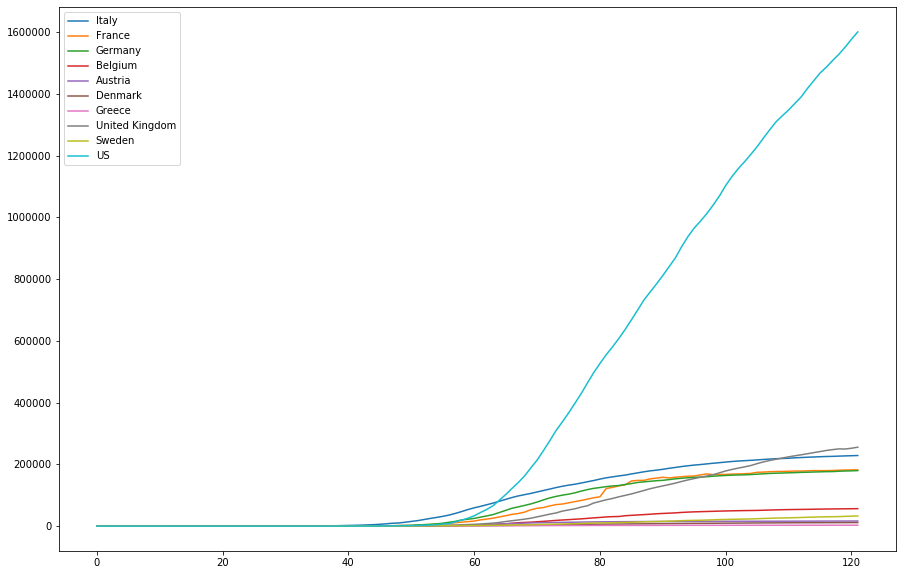

In [34]:
plt.figure(figsize=(15,10))
for country in country_dict.keys():
    plt.plot(country_dict[country])
    
plt.legend(country_dict.keys())
plt.show()